In [27]:
import pandas as pd
import numpy as np
import datetime as dt
import h5py
import math as ma
from astropy.io import fits
from astropy.time import Time
from matplotlib import pyplot as plt
from matplotlib.axis import Axis
from pyuvdata import UVData
import matplotlib as mpl

In [ ]:
df = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/observation_id/observation_id.csv", header=0, engine='python')
df['date'] = df.starttime_utc.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.000Z").date())
df['date_time'] = df.starttime_utc.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.000Z"))
df['partition'] = pd.factorize(df['date'])[0] + 1
df = df[df['partition'] == 1].reset_index(drop=True)

---

#### Checking the results normal vs faster algorithm

In [ ]:
df_sel_rfi_fast = pd.DataFrame()
transform_tb = np.repeat(np.arange(0,14,1), 4)

for n in range(1):
    #with h5py.File('/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/faster/win_z_scores_data_day_1_grid_%s_integration_8_real.h5' %(n), "r") as f:
    with h5py.File('/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/3/win_z_scores_data_day_1_grid_%s_integration_8_real.h5' %(n), "r") as f:
        data = f["wins_z_score"][:]
        obs_id = f["obs_id"][:]
        time_blocks = f["time_blocks"][:]

    flat_data = data.reshape(-1, data.shape[-1])
    
    # Create DataFrame
    df_temp = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

    df_temp["obs_id"] = np.tile(obs_id, data.shape[1]*data.shape[2])
    df_temp["time_index"] = np.repeat(np.arange(data.shape[0]), data.shape[1] * data.shape[2])
    df_temp["frequency"] = np.tile(np.arange(data.shape[2]), data.shape[0] * data.shape[1])
    df_temp["antenna"] = np.tile(np.repeat(np.arange(data.shape[1]), data.shape[2]), data.shape[0])
    df_temp["obs_id"] = df_temp['time_index'].map(lambda t: obs_id[t])
    df_temp["timeblock"] = df_temp['time_index'].map(lambda t: int(time_blocks[t]))
    #df_temp['timeblock'] = df_temp.timeblock.apply(lambda x: np.where(transform_tb == x)[0].tolist())
    #df_temp = df_temp.explode('timeblock').reset_index(drop=True)

    df_sel_rfi_fast = pd.concat([df_sel_rfi_fast, df_temp]).reset_index(drop = True)


In [ ]:
df_sel_rfi_slow = pd.DataFrame()
for o in range(1):
    #aa = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/slower/both_side_selected_outliers_3_sigma_day_1_grid_[%s]_iter_100_real_part_8s.csv" %(o), header=None)
    aa = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/slower/observation_data/both_side_selected_outliers_3_sigma_day_1_grid_[%s]_iter_100_real_part_8s.csv" %(o), header=None)
    aa.columns = ['xx', 'yy', 'obs_id', 'timeblocks', 'tile', 'freqs', 'z_score', 'polarization']
    aa = aa[~aa['z_score'].isna()].reset_index(drop=True)
    aa['z_score'] = aa['z_score'].astype(float)
    aa['floor_z_score'] = aa['z_score'].apply(lambda x: ma.floor(x))
    df_sel_rfi_slow = pd.concat([df_sel_rfi_slow, aa]).reset_index(drop = True)

In [ ]:
np.unique(df_sel_rfi_fast['obs_id'])

In [ ]:
df_sel_rfi_fast[df_sel_rfi_fast['obs_id'] == 1095450824].head(10)

In [ ]:
df_sel_rfi_slow[(df_sel_rfi_slow['obs_id'] == 1095450824) & (df_sel_rfi_slow['freqs'] == 0) & (df_sel_rfi_slow['tile'] == 0) & (df_sel_rfi_slow['timeblocks'] == 0)]

---

#### Min max comparison

In [ ]:
df_stat_slow = pd.DataFrame()
for o in range(1):
    #oo = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/slower/both_side_outliers_statistics_3_sigma_day_1_grid_[%s]_iter_100_real_part_8s.csv" %(o), header=None)
    oo = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/slower/observation_data/both_side_outliers_statistics_3_sigma_day_1_grid_[%s]_iter_100_real_part_8s.csv" %(o), header=None)
    oo.columns = ['tile', 'freqs', 'polarization', 'skewness', 'max', 'min', 'mean', 'win_mean', 'std', 'win_std', 'gamma_final', 'number_of_outliers']
    oo['grid'] = o
    df_stat_slow = pd.concat([df_stat_slow, oo]).reset_index(drop = True)

In [ ]:
df_stat_fast = pd.DataFrame()
for o in range(1):
    #oo = pd.read_parquet("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/faster/outlier_statistics_day_1_grid_%s_integration_8_real.parquet" %(o))
    oo = pd.read_parquet("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/3/outlier_statistics_day_1_grid_%s_integration_8_real.parquet" %(o))
    oo['grid'] = o
    df_stat_fast = pd.concat([df_stat_fast, oo]).reset_index(drop = True)

In [ ]:
df_gamma_fast = pd.DataFrame()
for o in range(1):
    #oo = pd.read_parquet("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/faster/final_gamma_day_1_grid_%s_integration_8_real.parquet" %(o))
    oo = pd.read_parquet("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/3/final_gamma_day_1_grid_%s_integration_8_real.parquet" %(o))
    oo['grid'] = o
    df_gamma_fast = pd.concat([df_gamma_fast, oo]).reset_index(drop = True)

In [ ]:
df_stat_slow[(df_stat_slow['tile'] == 6) & (df_stat_slow['freqs'] == 100)]

In [ ]:
df_stat_fast[(df_stat_fast['antenna'] == 6) & (df_stat_fast['frequency'] == 100) & (df_stat_fast['polarization'].isin([0,3]))]

In [ ]:
df_gamma_fast[(df_gamma_fast['antenna'] == 6) & (df_gamma_fast['frequency'] == 100) & (df_stat_fast['polarization'].isin([0,3]))]

---

In [ ]:
df_sel_rfi_fast = pd.DataFrame()
transform_tb = np.repeat(np.arange(0,14,1), 4)

for n in range(1):
    with h5py.File('/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/win_z_scores_data_day_1_grid_%s_integration_8_real.h5' %(n), "r") as f:
        data = f["wins_z_score"][:]
        obs_id = f["obs_id"][:]
        time_blocks = f["time_blocks"][:]

    flat_data = data.reshape(-1, data.shape[-1])
    
    # Create DataFrame
    df_temp = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

    df_temp["obs_id"] = np.tile(obs_id, data.shape[1]*data.shape[2])
    df_temp["time_index"] = np.repeat(np.arange(data.shape[0]), data.shape[1] * data.shape[2])
    df_temp["frequency"] = np.tile(np.arange(data.shape[2]), data.shape[0] * data.shape[1])
    df_temp["antenna"] = np.tile(np.repeat(np.arange(data.shape[1]), data.shape[2]), data.shape[0])
    df_temp["obs_id"] = df_temp['time_index'].map(lambda t: obs_id[t])
    df_temp["timeblock"] = df_temp['time_index'].map(lambda t: int(time_blocks[t]))
    #df_temp['timeblock'] = df_temp.timeblock.apply(lambda x: np.where(transform_tb == x)[0].tolist())
    #df_temp = df_temp.explode('timeblock').reset_index(drop=True)

    df_sel_rfi_fast = pd.concat([df_sel_rfi_fast, df_temp]).reset_index(drop = True)


In [ ]:
df_sel_rfi_fast[df_sel_rfi_fast['time_index'] == 0]

In [ ]:
f = fits.open(f"/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/calibration_solutions/20250712_observation_data_8s_before_with_cotter_time_corrections_without_flags/uvfits/calibrated_fits/hyperdrive_solutions_1095450704.fits")

In [ ]:
f['SOLUTIONS'].data[:, :, :, ::2]

In [ ]:
g = fits.open(f"/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/calibration_solutions/20240831_multiple_simulation_higher_thermal_noise_sn3_8s/uvfits/calibrated_fits/hyperdrive_solutions_1095450704.fits")

In [ ]:
g['SOLUTIONS'].data[:, :, :, ::2]

---

#### Importing h5 file for flagging

In [28]:
with h5py.File('/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/outliers_location_day_1_grid_%s_integration_8_real.h5' %(0), "r") as f:
    data = f["outliers_mask"][:]
    obs_id = f["obs_id"][:]
    time_blocks = f["time_blocks"][:]

In [29]:
flat_data = data.reshape(-1, data.shape[-1])
    
# Create DataFrame
df_temp = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

df_temp["obs_id"] = np.tile(obs_id, data.shape[1]*data.shape[2])
df_temp["time_index"] = np.repeat(np.arange(data.shape[0]), data.shape[1] * data.shape[2])
df_temp["frequency"] = np.tile(np.arange(data.shape[2]), data.shape[0] * data.shape[1])
df_temp["antenna"] = np.tile(np.repeat(np.arange(data.shape[1]), data.shape[2]), data.shape[0])
df_temp["obs_id"] = df_temp['time_index'].map(lambda t: obs_id[t])
df_temp["timeblock"] = df_temp['time_index'].map(lambda t: int(time_blocks[t]))

In [48]:
dfs = df_temp[(df_temp['XX'] == True) | (df_temp['YY'] == True)].reset_index(drop=True)

In [49]:
sel_dfs = dfs[dfs['obs_id'] == 1095451432]['frequency'].value_counts().to_frame().reset_index()

In [60]:
dfs[dfs['frequency'].isin(sel_dfs[sel_dfs['count'] > 10]['frequency'].to_list())]

,XX,XY,YX,YY,obs_id,time_index,frequency,antenna,timeblock
23,True,False,False,False,1095450704,1,531,5,1
649,True,False,False,False,1095450704,2,610,23,2
753,True,False,False,False,1095450704,2,531,104,2
755,True,False,False,False,1095450704,2,570,104,2
907,True,False,True,False,1095450704,3,570,97,3
...,...,...,...,...,...,...,...,...,...
56983,True,True,True,True,1095452528,221,580,123,11
56987,True,True,True,True,1095452528,221,580,124,11
56991,True,True,True,True,1095452528,221,580,125,11
56996,True,True,True,True,1095452528,221,580,126,11


In [57]:
sel_dfs[sel_dfs['count'] > 10]['frequency'].to_list()

[625, 570, 610, 550, 580, 530, 430, 450, 531]

In [36]:
# Number of antenna affected the detected RFI similar to AOFlagger
len(np.unique(dfs[(dfs['obs_id'] == 1095451432) & (dfs['frequency'] == 625)]['antenna']))

126

In [38]:
# Number of antenna affected the detected RFI
len(np.unique(dfs[(dfs['obs_id'] == 1095451432) & (dfs['frequency'] == 570)]['antenna']))

124

In [41]:
# Number of antenna affected the detected RFI
len(np.unique(dfs[(dfs['obs_id'] == 1095451432) & (dfs['frequency'] == 540)]['antenna']))

6

---

#### Testing plot

In [ ]:
def plot_flags(ss: UVData, args, obsname, suffix, cmap):
    """Plot the flag occupancy."""
    pols = ss.get_pols()
    gps_times = get_gps_times(ss)
    freqs_mhz = (ss.freq_array) / 1e6

    occupancy = np.nansum(
        ss.flag_array.reshape(ss.Ntimes, ss.Nbls, ss.Nspws, ss.Nfreqs, len(pols)),
        axis=(1, 2, 4),
    ).astype(np.float64)
    full_occupancy_value = ss.Nbls * ss.Nspws * len(pols)
    occupancy[occupancy == full_occupancy_value] = np.nan
    max_occupancy = np.nanmax(occupancy)
    print(f"{max_occupancy=} {full_occupancy_value=}")
    # clip at half occupancy
    # occupancy[occupancy >= full_occupancy_value / 2] = full_occupancy_value / 2

    occupancy /= full_occupancy_value

    plt.suptitle(f"{obsname} occupancy{suffix} {pols[0] if len(pols) == 1 else ''}")
    plt.imshow(
        occupancy[...],
        aspect="auto",
        interpolation="none",
        cmap=cmap,
        extent=[
            np.min(freqs_mhz),
            np.max(freqs_mhz),
            np.max(gps_times),
            np.min(gps_times),
        ],
    )

    # add a color bar
    cbar = plt.colorbar()
    cbar.set_label("Flag occupancy")

    plt.ylabel("GPS Time [s]")
    plt.xlabel("Frequency channel [MHz]")

    plt.gcf().set_size_inches(16, np.min([9, 4 * len(pols)]))

In [ ]:
with_no_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/1095451432_w_no_flags059-078.uvfits")
date_unique, unique_id = np.unique(with_no_flags[0].data['DATE'], return_inverse=True)

reshaped_no_flags = with_no_flags[0].data.data.reshape(len(np.unique(with_no_flags[0].data['BASELINE'])), len(date_unique), with_no_flags[0].data.data.shape[3], with_no_flags[0].data.data.shape[4], with_no_flags[0].data.data.shape[5])
weights = reshaped_no_flags[..., 2]  # shape: (8128, 56, 640, 4)
flags = weights < 0  # boolean array of same shape

flags = np.transpose(flags, (1, 2, 0, 3))  # shape: (56, 640, 8128, 4)
flag_counts = np.sum(flags, axis=(2, 3))  # shape: (56, 640)

total_possible = flags.shape[2] * flags.shape[3]  # 8128 × 4 = 32512
occupancy = flag_counts / total_possible  # shape: (56, 640)

In [ ]:
occupancy

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap that maps NaN to black
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='black')  # set NaNs to black

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    occupancy,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[0, 640, 56, 0]
)
plt.colorbar(label="Flag occupancy (fraction)")
plt.xlabel("Frequency channel")
plt.ylabel("Time index")
plt.title("Flag Occupancy (NaNs shown in black)")
plt.tight_layout()
plt.show()


##### Working

##### No flags

In [19]:
total_channels = 640
center_channel = 321
center_freq_mhz = 87.68
channel_spacing_mhz = 0.04  # 40 kHz

# Calculate first and last frequencies
start_freq = center_freq_mhz - (center_channel * channel_spacing_mhz)
end_freq = center_freq_mhz + ((total_channels - center_channel - 1) * channel_spacing_mhz)

In [5]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

with_no_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/1095451432_w_no_flags059-078.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(with_no_flags[0].data['DATE'], return_inverse=True)

# Reshape data
reshaped_no_flags = with_no_flags[0].data.data.reshape(
    len(date_unique),
    len(np.unique(with_no_flags[0].data['BASELINE'])),
    with_no_flags[0].data.data.shape[3],
    with_no_flags[0].data.data.shape[4],
    with_no_flags[0].data.data.shape[5]
)

# Extract weights and flags
weights_no_flags = reshaped_no_flags[..., 2]  # shape: (56, 8128, 640, 4)
flags_no_flags = weights_no_flags < 0                  # boolean array of shape (56, 8128, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
flags_no_flags = np.transpose(flags_no_flags, (0, 2, 1, 3))  # shape: (56, 640, 8128, 4)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol_no_flags = flags_no_flags[..., pol_idx]           # shape: (56, 640, 8128)

# Sum over baselines
flag_counts_no_flags = np.sum(flags_pol_no_flags, axis=2)   # shape: (56, 640)

# Normalize by total number of baselines
total_possible_no_flags = flags_pol_no_flags.shape[2]
occupancy_no_flags = flag_counts_no_flags / total_possible_no_flags  # shape: (56, 640)

##### with flags

In [6]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

with_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/uvfits_update/1095451432_w_no_flags059-078_flagged.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(with_flags[0].data['DATE'], return_inverse=True)

reshaped_with_flags = with_flags[0].data.data.reshape(
    len(date_unique),
    len(np.unique(with_flags[0].data['BASELINE'])),
    with_flags[0].data.data.shape[3],
    with_flags[0].data.data.shape[4],
    with_flags[0].data.data.shape[5])

# Extract weights and flags
weights_with_flags = reshaped_with_flags[..., 2]  # shape: (56, 8128, 640, 4)
print("weights shape: ", weights_with_flags.shape)
flags_with_flags = weights_with_flags < 0                  # boolean array of shape (56, 8128, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
flags_with_flags = np.transpose(flags_with_flags, (0, 2, 1, 3))  # shape: (56, 640, 8128, 4)
print("flagss shape: ", flags_with_flags.shape)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol_with_flags = flags_with_flags[..., pol_idx]           # shape: (56, 640, 8128)
print("flags_pol shape: ", flags_pol_with_flags.shape)

# Sum over baselines
flag_counts_with_flags = np.sum(flags_pol_with_flags, axis=2)   # shape: (56, 640)
print("flags_counts shape: ", flag_counts_with_flags.shape)

# Normalize by total number of baselines
total_possible_with_flags = flags_pol_with_flags.shape[2]
occupancy_with_flags = flag_counts_with_flags / total_possible_with_flags  # shape: (56, 640)

weights shape:  (56, 8128, 640, 4)
flagss shape:  (56, 640, 8128, 4)
flags_pol shape:  (56, 640, 8128)
flags_counts shape:  (56, 640)


In [ ]:
occupancy_total = occupancy_with_flags - occupancy_no_flags

##### AOF win flags

In [10]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

aof_wins = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/1095451432_w_flags_corrections_time_edges059-078_wins_flags_allbl_5.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(aof_wins[0].data['DATE'], return_inverse=True)

reshaped_aof_wins = aof_wins[0].data.data.reshape(
    len(date_unique),
    len(np.unique(aof_wins[0].data['BASELINE'])),
    aof_wins[0].data.data.shape[3],
    aof_wins[0].data.data.shape[4],
    aof_wins[0].data.data.shape[5])

# Extract weights and flags
weights_aof_wins = reshaped_aof_wins[..., 2]  # shape: (56, 8128, 640, 4)
print("weights shape: ", weights_aof_wins.shape)
flags_aof_wins = weights_aof_wins < 0                  # boolean array of shape (56, 8128, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
flags_aof_wins = np.transpose(flags_aof_wins, (0, 2, 1, 3))  # shape: (56, 640, 8128, 4)
print("flagss shape: ", flags_aof_wins.shape)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol_aof_wins = flags_aof_wins[..., pol_idx]           # shape: (56, 640, 8128)
print("flags_pol shape: ", flags_pol_aof_wins.shape)

# Sum over baselines
flag_counts_aof_wins = np.sum(flags_pol_aof_wins, axis=2)   # shape: (56, 640)
print("flags_counts shape: ", flag_counts_aof_wins.shape)

# Normalize by total number of baselines
total_possible_aof_wins = flags_pol_aof_wins.shape[2]
occupancy_aof_wins = flag_counts_aof_wins / total_possible_aof_wins  # shape: (56, 640)

weights shape:  (56, 8128, 640, 4)
flagss shape:  (56, 640, 8128, 4)
flags_pol shape:  (56, 640, 8128)
flags_counts shape:  (56, 640)


In [11]:
occupancy_total_aof_wins = occupancy_aof_wins - occupancy_no_flags

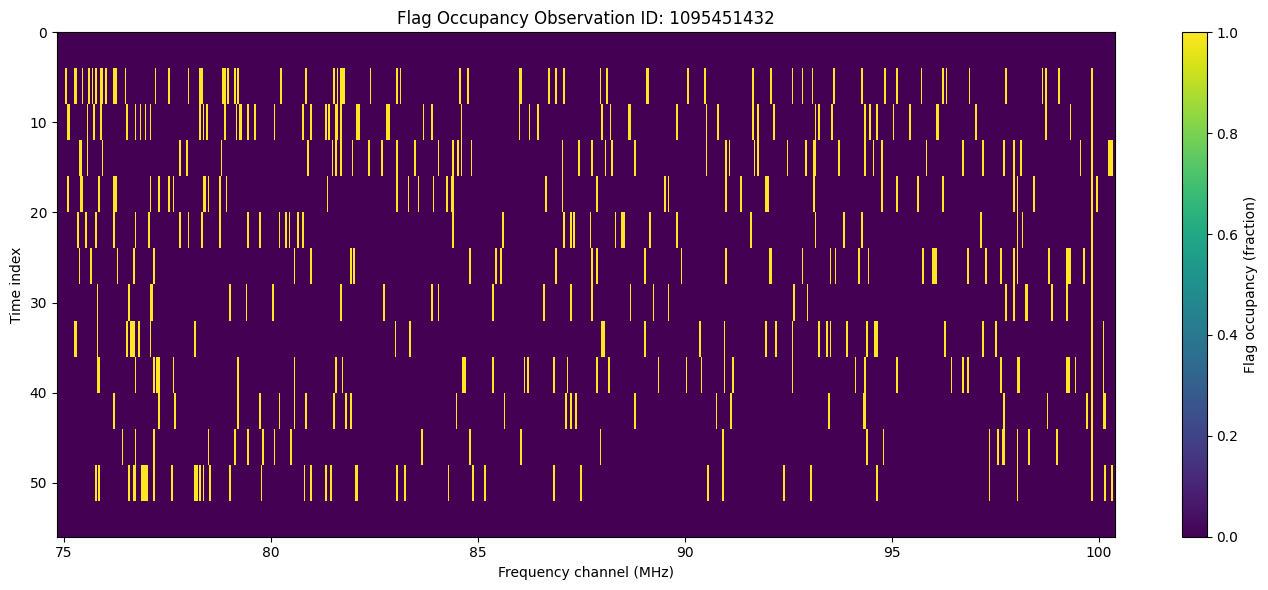

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap that maps NaN to black
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='black')  # set NaNs to black

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    occupancy_total,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[start_freq, end_freq, 56, 0]
)
plt.colorbar(label="Flag occupancy (fraction)")
plt.xlabel("Frequency channel (MHz)")
plt.ylabel("Time index")
plt.title("Flag Occupancy Observation ID: 1095451432")
plt.tight_layout()
plt.show()


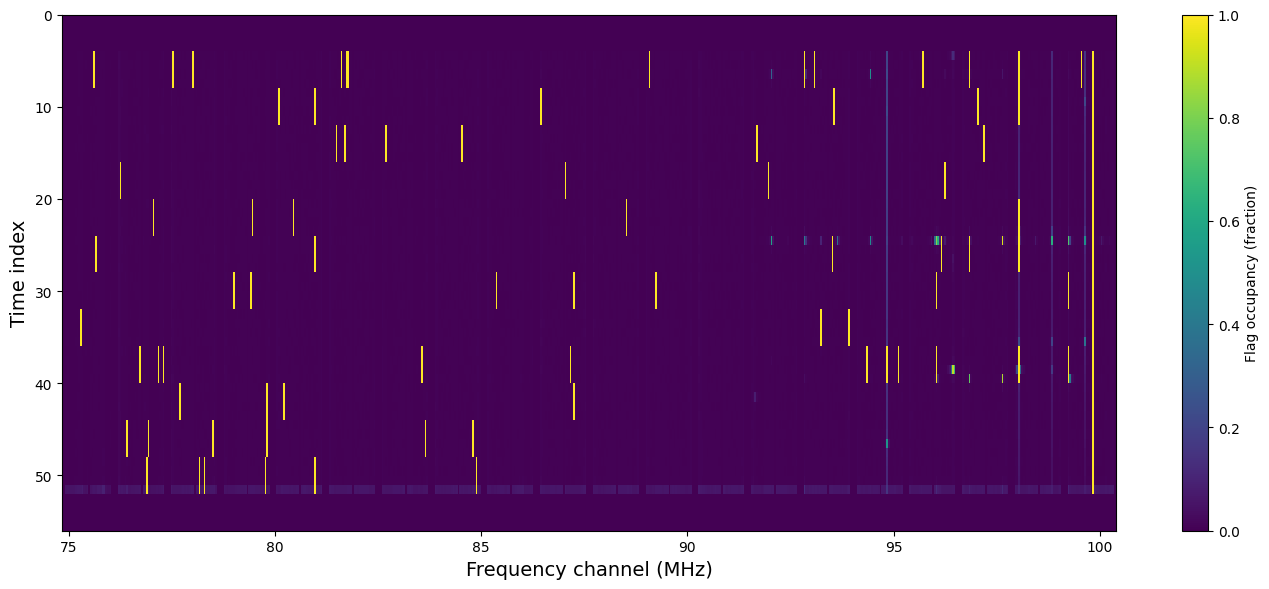

In [98]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap that maps NaN to black
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='black')  # set NaNs to black

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    occupancy_total_aof_wins,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[start_freq, end_freq, 56, 0], vmin=0, vmax=1.
)
plt.colorbar(label="Flag occupancy (fraction)")
plt.xlabel("Frequency channel (MHz)", fontsize=14)
plt.ylabel("Time index", fontsize=14)
#plt.title("Flag Occupancy Observation ID: 1095451432", fontsize=14)
plt.tight_layout()
plt.show()


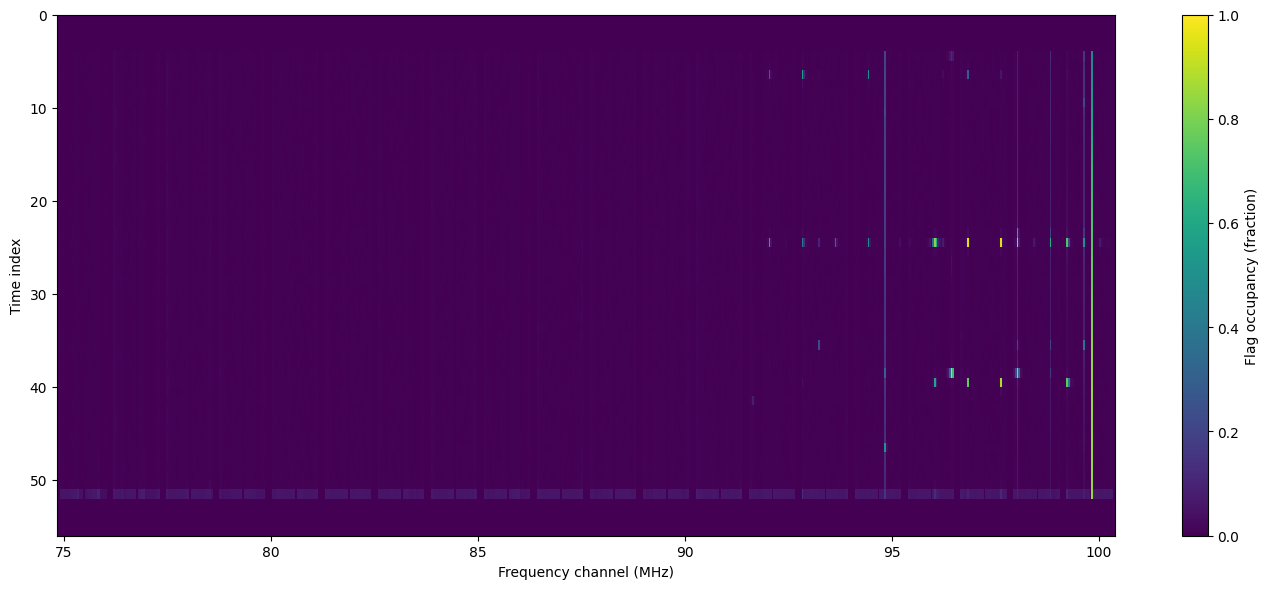

In [97]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap that maps NaN to black
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='black')  # set NaNs to black

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    occupancy_aof,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[start_freq, end_freq, 56, 0], vmin=0, vmax=1.
)
plt.colorbar(label="Flag occupancy (fraction)")
plt.xlabel("Frequency channel (MHz)")
plt.ylabel("Time index")
#plt.title("Flag Occupancy Observation ID: 1095451432")
plt.tight_layout()
plt.show()


---

##### Trial

In [82]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

with_trial = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/uvfits_update/1095451432_w_no_flags059-078_flagged.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(with_trial[0].data['DATE'], return_inverse=True)

reshaped_with_trial = with_trial[0].data.data.reshape(
    len(date_unique),
    len(np.unique(with_trial[0].data['BASELINE'])),
    with_trial[0].data.data.shape[3],
    with_trial[0].data.data.shape[4],
    with_trial[0].data.data.shape[5])

# Extract weights and flags
weights_with_trial = reshaped_with_trial[..., 2]  # shape: (56, 8128, 640, 4)
print("weights shape: ", weights_with_trial.shape)
flags_with_trial = weights_with_trial < 0                  # boolean array of shape (56, 8128, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
flags_with_trial = np.transpose(flags_with_trial, (0, 2, 1, 3))  # shape: (56, 640, 8128, 4)
print("flagss shape: ", flags_with_trial.shape)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol_with_trial = flags_with_trial[..., pol_idx]           # shape: (56, 640, 8128)
print("flags_pol shape: ", flags_pol_with_trial.shape)

# Sum over baselines
flag_counts_with_trial = np.sum(flags_pol_with_trial, axis=2)   # shape: (56, 640)
print("flags_counts shape: ", flag_counts_with_trial.shape)

# Normalize by total number of baselines
total_possible_with_trial = flags_pol_with_trial.shape[2]
occupancy_with_trial = flag_counts_with_trial / total_possible_with_trial  # shape: (56, 640)

weights shape:  (56, 8128, 640, 4)
flagss shape:  (56, 640, 8128, 4)
flags_pol shape:  (56, 640, 8128)
flags_counts shape:  (56, 640)


In [83]:
occupancy_total_trial = occupancy_with_trial - occupancy_no_flags

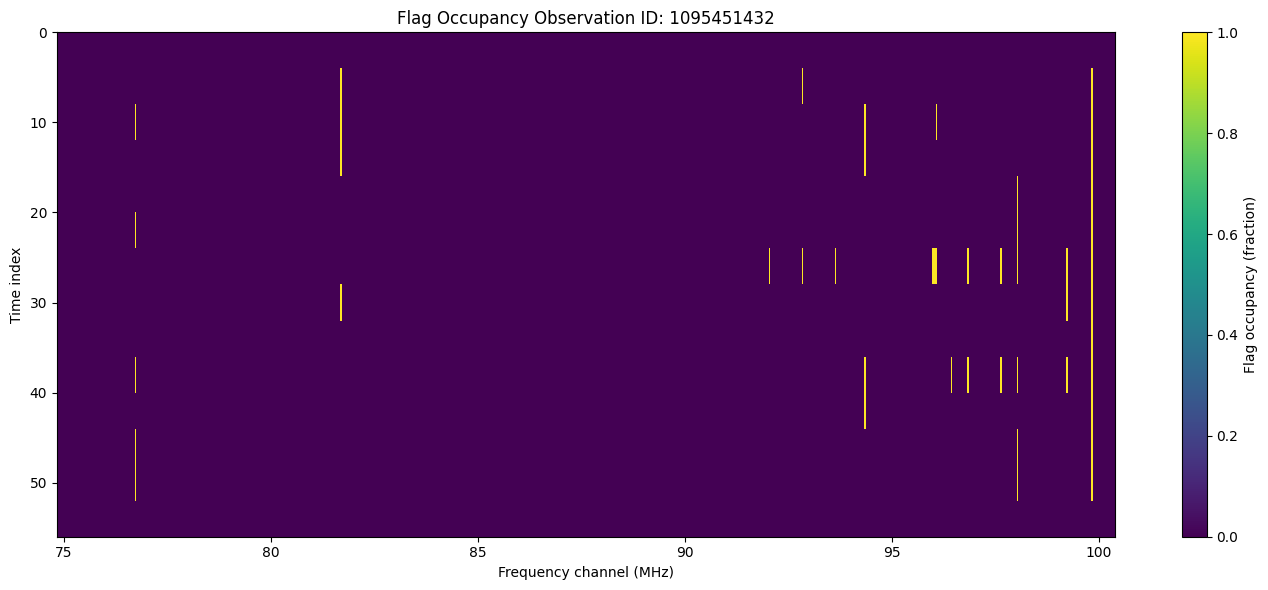

In [75]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap that maps NaN to black
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='black')  # set NaNs to black

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    occupancy_total_trial,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[start_freq, end_freq, 56, 0]
)
plt.colorbar(label="Flag occupancy (fraction)")
plt.xlabel("Frequency channel (MHz)")
plt.ylabel("Time index")
plt.title("Flag Occupancy Observation ID: 1095451432")
plt.tight_layout()
plt.show()


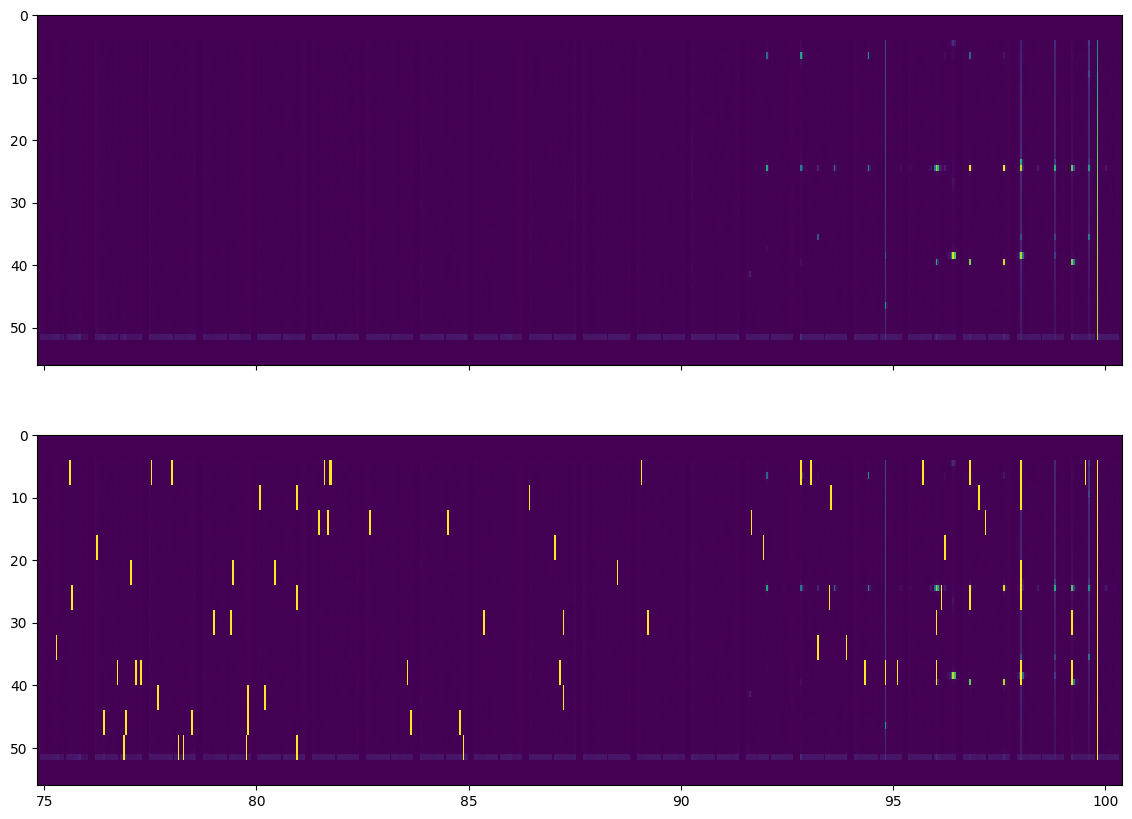

In [100]:
fig, axs = plt.subplots(2,1, figsize=(14, 10), facecolor='white', sharex=True)

#axs[0].imshow(
#    occupancy_total_trial,
#    aspect='auto',
#    interpolation='none',
#    cmap=cmap,
#    extent=[start_freq, end_freq, 56, 0])
axs[0].imshow(
    occupancy_aof,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[start_freq, end_freq, 56, 0])
axs[1].imshow(
    occupancy_total_aof_wins,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[start_freq, end_freq, 56, 0])

##### AOFlagger

In [17]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

aof_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/1095451432_w_flags_corrections_time_edges059-078.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(aof_flags[0].data['DATE'], return_inverse=True)

reshaped_aof_flags = aof_flags[0].data.data.reshape(
    len(date_unique),
    len(np.unique(aof_flags[0].data['BASELINE'])),
    aof_flags[0].data.data.shape[3],
    aof_flags[0].data.data.shape[4],
    aof_flags[0].data.data.shape[5])

# Extract weights and flags
weights_aof = reshaped_aof_flags[..., 2]  # shape: (56, 8128, 640, 4)
print("weights shape: ", weights_aof.shape)
flags_aof = weights_aof < 0                  # boolean array of shape (56, 8128, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
flags_aof = np.transpose(flags_aof, (0, 2, 1, 3))  # shape: (56, 640, 8128, 4)
print("flagss shape: ", flags_aof.shape)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol_aof = flags_aof[..., pol_idx]           # shape: (56, 640, 8128)
print("flags_pol shape: ", flags_pol_aof.shape)

# Sum over baselines
flag_counts_aof = np.sum(flags_pol_aof, axis=2)   # shape: (56, 640)
print("flags_counts shape: ", flag_counts_aof.shape)

# Normalize by total number of baselines
total_possible_aof = flags_pol_aof.shape[2]
occupancy_aof = flag_counts_aof / total_possible_aof  # shape: (56, 640)
occupancy_aof[occupancy_aof == 1.0] = 1e-6

weights shape:  (56, 8128, 640, 4)
flagss shape:  (56, 640, 8128, 4)
flags_pol shape:  (56, 640, 8128)
flags_counts shape:  (56, 640)


---

##### with flags

In [ ]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

with_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/uvfits_update/1095451432_w_no_flags059-078_flagged.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(with_flags[0].data['DATE'], return_inverse=True)

# Reshape data
#reshaped_with_flags = with_flags[0].data.data.reshape(
#    len(np.unique(with_flags[0].data['BASELINE'])),
#    len(date_unique),
#    with_flags[0].data.data.shape[3],
#    with_flags[0].data.data.shape[4],
#    with_flags[0].data.data.shape[5])

reshaped_with_flags = with_flags[0].data.data.reshape(
    len(date_unique),
    len(np.unique(with_flags[0].data['BASELINE'])),
    with_flags[0].data.data.shape[3],
    with_flags[0].data.data.shape[4],
    with_flags[0].data.data.shape[5])

# Extract weights and flags
weights = reshaped_with_flags[..., 2]  # shape: (8128, 56, 640, 4)
print("weights shape: ", weights.shape)
flags = weights < 0                  # boolean array of shape (8128, 56, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
#flags = np.transpose(flags, (1, 2, 0, 3))  # shape: (56, 640, 8128, 4)
flags = np.transpose(flags, (0, 2, 1, 3))  # shape: (56, 640, 8128, 4)
print("flagss shape: ", flags.shape)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol = flags[..., pol_idx]           # shape: (56, 640, 8128)
print("flags_pol shape: ", flags_pol.shape)

# Sum over baselines
flag_counts = np.sum(flags_pol, axis=2)   # shape: (56, 640)
print("flags_counts shape: ", flag_counts.shape)

# Normalize by total number of baselines
total_possible = flags_pol.shape[2]
occupancy = flag_counts / total_possible  # shape: (56, 640)
#occupancy[occupancy == 1.0] = 1e-6

##### AOFlagger

In [ ]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

aof_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/1095451432_w_flags_corrections_time_edges059-078.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(aof_flags[0].data['DATE'], return_inverse=True)

# Reshape data
reshaped_no_flags = aof_flags[0].data.data.reshape(
    len(np.unique(aof_flags[0].data['BASELINE'])),
    len(date_unique),
    aof_flags[0].data.data.shape[3],
    aof_flags[0].data.data.shape[4],
    aof_flags[0].data.data.shape[5]
)

# Extract weights and flags
weights = reshaped_no_flags[..., 2]  # shape: (8128, 56, 640, 4)
flags = weights < 0                  # boolean array of shape (8128, 56, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
flags = np.transpose(flags, (1, 2, 0, 3))  # shape: (56, 640, 8128, 4)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol = flags[..., pol_idx]           # shape: (56, 640, 8128)

# Sum over baselines
flag_counts = np.sum(flags_pol, axis=2)   # shape: (56, 640)

# Normalize by total number of baselines
total_possible = flags_pol.shape[2]
occupancy = flag_counts / total_possible  # shape: (56, 640)
occupancy[occupancy == 1.0] = 1e-6

In [ ]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

aof_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/1095451432_w_flags_corrections_time_edges059-078.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(aof_flags[0].data['DATE'], return_inverse=True)

# Reshape data
#reshaped_with_flags = with_flags[0].data.data.reshape(
#    len(np.unique(with_flags[0].data['BASELINE'])),
#    len(date_unique),
#    with_flags[0].data.data.shape[3],
#    with_flags[0].data.data.shape[4],
#    with_flags[0].data.data.shape[5])

reshaped_aof_flags = aof_flags[0].data.data.reshape(
    len(date_unique),
    len(np.unique(aof_flags[0].data['BASELINE'])),
    aof_flags[0].data.data.shape[3],
    aof_flags[0].data.data.shape[4],
    aof_flags[0].data.data.shape[5])

# Extract weights and flags
weights = reshaped_aof_flags[..., 2]  # shape: (56, 8128, 640, 4)
print("weights shape: ", weights.shape)
flags = weights < 0                  # boolean array of shape (56, 8128, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
#flags = np.transpose(flags, (1, 2, 0, 3))  # shape: (56, 640, 8128, 4)
flags = np.transpose(flags, (0, 2, 1, 3))  # shape: (56, 640, 8128, 4)
print("flagss shape: ", flags.shape)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol = flags[..., pol_idx]           # shape: (56, 640, 8128)
print("flags_pol shape: ", flags_pol.shape)

# Sum over baselines
flag_counts = np.sum(flags_pol, axis=2)   # shape: (56, 640)
print("flags_counts shape: ", flag_counts.shape)

# Normalize by total number of baselines
total_possible = flags_pol.shape[2]
occupancy = flag_counts / total_possible  # shape: (56, 640)
occupancy[occupancy == 1.0] = 1e-6